# Open Source Energy Modeling - 3 rd Homework - Task 2

### *Adding a new technology: gas power plant*

The following simple energy model using *MESSAGEix* is based on the Westeros Baseline Tutorials, which can be found [here](https://message.iiasa.ac.at/en/stable/tutorials.html). The baseline model was adaped by adding gas power plant as a new technology. In the secound part of the task, a CO2 bound was added to the model in order to determine a Carbon price under which Gas, Wind and Coal are used at the same time. For this the tutorials westeros_emissions_bounds and westeros_emissions_taxes were used.


## Part 1a - Adding gas power and defining parameters 



Like in the tutorial all the packages are imported. The *ixmp* `Platform` is your connection to a database for storing model input data and scenario results.

In [2]:
import pandas as pd
import ixmp
import message_ix

from message_ix.utils import make_df

%matplotlib inline

In [3]:
mp = ixmp.Platform()

A new `Scenario` is created to build our model.

In [4]:
scenario = message_ix.Scenario(mp, model='Westeros Electrified', 
                               scenario='baseline', version='new')

The model structure defining time and space is kept like in the tutorial.

In [5]:
history = [690]
model_horizon = [700, 710, 720]
scenario.add_horizon({'year': history + model_horizon,  
                      'firstmodelyear': model_horizon[0]})

In [6]:
country = 'Westeros'
scenario.add_spatial_sets({'country': country})

A new technology called Gas is added.

In [7]:
scenario.add_set("commodity", ["electricity", "light"])
scenario.add_set("level", ["secondary", "final", "useful"])
scenario.add_set("technology", ['coal_ppl', 'wind_ppl', 'gas_ppl','grid', 'bulb'])
scenario.add_set("mode", "standard")

### Supply and Demand

The GDP profile is kept the same.

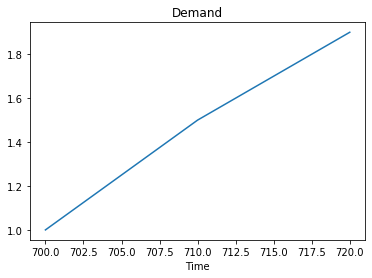

In [8]:
gdp_profile = pd.Series([1., 1.5, 1.9],
                        index=pd.Index(model_horizon, name='Time'))
gdp_profile.plot(title='Demand')

The demand is taken from the tutorial:

- 40 million people in [300 AC](https://atlasoficeandfireblog.wordpress.com/2016/03/06/the-population-of-the-seven-kingdoms/)
- similar population growth to Earth in the same time frame [(~factor of 12)](https://en.wikipedia.org/wiki/World_population_estimates)
- a per capita demand for electricity of 1000 kWh
- and 8760 hours in a year (of course!)


In [9]:
demand_per_year = 40 * 12 * 1000 / 8760
light_demand = pd.DataFrame({
        'node': country,
        'commodity': 'light',
        'level': 'useful',
        'year': model_horizon,
        'time': 'year',
        'value': (100 * gdp_profile).round(),
        'unit': 'GWa',
    })

In [10]:
scenario.add_par("demand", light_demand)

In order to define the input and output commodites of each technology, some common keys are defined.

In [11]:
year_df = scenario.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act']

base = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': '-',
}

base_input = make_df(base, node_origin=country, time_origin='year')
base_output = make_df(base, node_dest=country, time_dest='year')

In [12]:
bulb_out = make_df(base_output, technology='bulb', commodity='light', 
                   level='useful', value=1.0)
scenario.add_par('output', bulb_out)

bulb_in = make_df(base_input, technology='bulb', commodity='electricity',  
                  level='final', value=1.0)
scenario.add_par('input', bulb_in)

Because the grid has transmission losses, only 90% of the input electricity is available as output.

In [13]:
grid_efficiency = 0.9
grid_out = make_df(base_output, technology='grid', commodity='electricity', 
                   level='final', value=grid_efficiency)
scenario.add_par('output', grid_out)

grid_in = make_df(base_input, technology='grid', commodity='electricity',
                  level='secondary', value=1.0)
scenario.add_par('input', grid_in)

In- and Output of the new gas plant is added. (The model does not include the fossil resources used as `input` for coal plants; however, costs of coal extraction are included in the parameter $variable\_cost$.)

In [14]:
coal_out = make_df(base_output, technology='coal_ppl', commodity='electricity', 
                   level='secondary', value=1.)
scenario.add_par('output', coal_out)

wind_out = make_df(base_output, technology='wind_ppl', commodity='electricity', 
                   level='secondary', value=1.)
scenario.add_par('output', wind_out)

gas_out = make_df(base_output, technology='gas_ppl', commodity='electricity',
                  level='secondary', value=1.)
scenario.add_par('output', gas_out)

### Operational constraints

Alike coal the `capacity_factor` for gas is set to 1 as it is assumed that all installed capacity can be active at all time.

In [15]:
base_capacity_factor = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'time': 'year',
    'unit': '-',
}

In [16]:
capacity_factor = {
    'coal_ppl': 1,
    'wind_ppl': 0.36,
    'gas_ppl': 1,
    'bulb': 1, 
}

for tec, val in capacity_factor.items():
    df = make_df(base_capacity_factor, technology=tec, value=val)
    scenario.add_par('capacity_factor', df)

The `technical_lifetime` for a gas plant is added. The technical lifetime of a gas power plant is assumed to be 30 yrs. This information is taken from the [IEA ETSAP - Technology Brief E02](https://iea-etsap.org/E-TechDS/PDF/E02-gas_fired_power-GS-AD-gct.pdf) (page 4). 

In [17]:
base_technical_lifetime = {
    'node_loc': country,
    'year_vtg': model_horizon,
    'unit': 'y',
}

In [18]:
lifetime = {
    'coal_ppl': 20,
    'wind_ppl': 20,
    'gas_ppl': 30,
    'bulb': 1,
}

for tec, val in lifetime.items():
    df = make_df(base_technical_lifetime, technology=tec, value=val)
    scenario.add_par('technical_lifetime', df)

### Technological Diffusion and Contraction

Alike in the tutorial all technologies (incl. Gas) are limited in their ability to grow. The constraint is set at 10% per year.

In [19]:
base_growth = {
    'node_loc': country,
    'year_act': model_horizon,
    'time': 'year',
    'unit': '-',
}

In [20]:
growth_technologies = [
    "coal_ppl", 
    "wind_ppl",
    "gas_ppl", 
]

for tec in growth_technologies:
    df = make_df(base_growth, technology=tec, value=0.1) 
    scenario.add_par('growth_activity_up', df)

## Part 1b - Defining Energy Mix 

In the following part the energy mix is defined. For this model the a mix of 40% Wind (same as tutorial), 40% coal and 20% gas was chosen.

In [21]:
historic_demand = 0.85 * demand_per_year
historic_generation = historic_demand / grid_efficiency
coal_fraction = 0.4

In [22]:
base_capacity = {
    'node_loc': country,
    'year_vtg': history,
    'unit': 'GWa',
}

base_activity = {
    'node_loc': country,
    'year_act': history,
    'mode': 'standard',
    'time': 'year',
    'unit': 'GWa',
}

In [23]:
old_activity = {
    'coal_ppl': coal_fraction * historic_generation,
    'wind_ppl': 0.4 * historic_generation,
    'gas_ppl': 0.2 * historic_generation,
}

for tec, val in old_activity.items():
    df = make_df(base_activity, technology=tec, value=val)
    scenario.add_par('historical_activity', df)

In [24]:
act_to_cap = {
    'coal_ppl': 1 / 10 / capacity_factor['coal_ppl'] / 2, # 20 year lifetime
    'wind_ppl': 1 / 10 / capacity_factor['wind_ppl'] / 2,
    'gas_ppl': 1 / 10 / capacity_factor['gas_ppl'] / 3, # 30 year lifetime!
}

for tec in act_to_cap:
    value = old_activity[tec] * act_to_cap[tec]
    df = make_df(base_capacity, technology=tec, value=value)
    scenario.add_par('historical_new_capacity', df)

## Part 1c - Adding costs (Objective Function)

For the following cost parameters it is assumed that the gas plants run using combined-cycle gas turbines (CCGT). The reagarding costs are again taken from the [IEA ETSAP - Technology Brief E02](https://iea-etsap.org/E-TechDS/PDF/E02-gas_fired_power-GS-AD-gct.pdf) (page 4). 


The interest rate parameter is kept the same.

In [25]:
scenario.add_par("interestrate", model_horizon, value=0.05, unit='-')

### Investment Costs

The investment costs are assumed to be 1100 $/kW  ([IEA ETSAP - Technology Brief E02](https://iea-etsap.org/E-TechDS/PDF/E02-gas_fired_power-GS-AD-gct.pdf) (page 4))


In [26]:
base_inv_cost = {
    'node_loc': country,
    'year_vtg': model_horizon,
    'unit': 'USD/kW',
}

# Adding a new unit to the library
mp.add_unit('USD/kW')     

INFO:root:unit `USD/kW` is already defined in the platform instance


In [27]:
# in $ / kW (specific investment cost)
costs = {
    'coal_ppl': 500,
    'wind_ppl': 1500,
    'gas_ppl': 1100,
    'bulb': 5,
}

for tec, val in costs.items():
    df = make_df(base_inv_cost, technology=tec, value=val)
    scenario.add_par('inv_cost', df)

### Fixed O&M Costs

The fixes O&M costs are assumed to be 44 $/kW/a ([IEA ETSAP - Technology Brief E02](https://iea-etsap.org/E-TechDS/PDF/E02-gas_fired_power-GS-AD-gct.pdf) (page 4))

In [28]:
base_fix_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'unit': 'USD/kWa',
}

In [29]:
# in $ / kW / year (every year a fixed quantity is destinated to cover part of the O&M costs
# based on the size of the plant, e.g. lightning, labor, scheduled maintenance, etc.)

costs = {
    'coal_ppl': 30,
    'gas_ppl': 44,
    'wind_ppl': 10,
}

for tec, val in costs.items():
    df = make_df(base_fix_cost, technology=tec, value=val)
    scenario.add_par('fix_cost', df)

### Variable O&M Costs

[IEA ETSAP - Technology Brief E02](https://iea-etsap.org/E-TechDS/PDF/E02-gas_fired_power-GS-AD-gct.pdf) only states fixed and variable costs being 44 $/kW/a. Therefore 44 $/kWa is used as variable O&M costs even this doesn't match the units of the tutorial. 

In [30]:
base_var_cost = {
    'node_loc': country,
    'year_vtg': vintage_years,
    'year_act': act_years,
    'mode': 'standard',
    'time': 'year',
    'unit': 'USD/kWa',
}

In [31]:
costs = {
    'coal_ppl': 30,
    'gas_ppl': 44,
    'grid': 50,
}

for tec, val in costs.items():
    df = make_df(base_var_cost, technology=tec, value=val)
    scenario.add_par('var_cost', df)

### Solving the Model

In [32]:
from message_ix import log

log.info('version number prior to commit: {}'.format(scenario.version))

scenario.commit(comment='basic model of Westeros electrification')

log.info('version number prior committing to the database: {}'.format(scenario.version))

INFO:message_ix:version number prior to commit: 0
INFO:message_ix:version number prior committing to the database: 20


In [33]:
scenario.set_as_default()

In [34]:
scenario.solve()

In [35]:
scenario.var('OBJ')['lvl']

251027.28125

## Part 2a - Adding Emission Bound

Gas emissions of 340 kg/MWh. Conver

In [36]:
import pandas as pd
import ixmp
import message_ix

from message_ix.utils import make_df

%matplotlib inline

In [ ]:
mp = ixmp.Platform()

In [37]:
model = 'Westeros Electrified'

base = message_ix.Scenario(mp, model=model, scenario='baseline')
scen = base.clone(model, 'emission_bound','introducing an upper bound on emissions',
                  keep_solution=False)
scen.check_out()

INFO:ixmp.backend.jdbc:launching ixmp.Platform connected to jdbc:hsqldb:file:C:/Users/Luisa/.local/share/ixmp/localdb/default


In [ ]:
year_df = scen.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act']
model_horizon = scen.set('year')
country = 'Westeros'

In [165]:
mp.close_db()